In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Kelly Criterion 
[(ref)](https://medium.com/@The-Quant-Trading-Room/the-ultimate-trading-strategy-how-to-combine-kelly-criteria-and-monte-carlo-simulation-d9ce8cc2c2bc)
Let $f$ be the percentage of total capital one decides to bet and $1-f$ be the percentage of the capital to be invested to a bank with interest rate $r>0$. Suppose the return rate $X$ follows $\mathcal{N}(\mu,\sigma^2)$,
we consider the maximization of expected log wealth over the fraction $f$ and the optimal fraction:
$$
\sup_{f \in \mathbb{R}}E(\ln(1+fX+ (1-f)r)) \; \Rightarrow \; f^* = \frac{\mu-r}{\sigma^2}
$$
We can run simulation for the price path and see the performance of Kelly criterion for long peroids
or run the backtest for the given input data. We can also include some conditions , e.g fractional Kelly(only invest $\alpha f^*$ for some $\alpha \in (0,1)$ ) or leverage limit ( $f^* \wedge k$ for some integer $k>1$).

input : log return $x_t$ from data or random generated, output: growth rate sequence 
$\{\prod_{s=1}^t(1+f^* x_s + (1-f^*)r)\}_{t \geq 1}$

In [97]:
def kelly(return_array,rate,kelly_cap,kelly_frac):
    mu = np.mean(return_array)
    var = np.var(return_array)
    if kelly_cap == False: #no restricion for leverage
        f_opt = (mu-rate)/var *kelly_frac  #allow shorting , f_opt can be negative
    else:
        f_opt = min((mu-rate)/var ,kelly_cap)*kelly_frac 
    wealth_array = np.ones(len(return_array)+1)
    growth_array = np.zeros_like(return_array)
    for s in range(len(return_array)):
        growth_array[s] = (1+f_opt*return_array[s] + (1-f_opt)*rate)
        wealth_array[s+1] = wealth_array[s]*growth_array[s]
    return wealth_array,growth_array

### Simulation
We consider different fractional Kelly criterions and compare them and other strategies like buy and hold or arbitrary chosen weight for rebalancing.


Suppose the interest rate for one year is $4\%$, mean of
daily return is $0$ , standard deviation of daily return is $0.01$. We run the Kelly criterions daily for $10000$ days (~ $27$ years) with $\alpha = 1 , 0.8 , 0.5 , 0.2$, buying $50\%$ and holds, buying $100\%,50\% ,0\% $ and
rebalancing.

B&H =$\{\frac{1}{2} \prod_{s=1}^t (1+x_s) + \frac{1}{2}\prod_{s=1}^t (1+r)\}_{t\geq 1}$ 

arbitrary weight = $\{\prod_{s=1}^t(1+\theta x_s + (1-\theta)r)\}_{t \geq 1}$ for some $\theta \in [0,1]$

In [96]:
def BnH(return_array,rate):
    wealth_array = np.ones(len(return_array)+1)
    stock=0.5
    bank=0.5
    growth_array = np.zeros_like(return_array)
    for s in range(len(return_array)):
        stock=stock*(1+return_array[s])
        bank= bank*(1+rate)
        wealth_array[s+1]= stock+bank
        growth_array[s] = wealth_array[s+1]/wealth_array[s]
    return wealth_array,growth_array
def arbitrary(return_array,rate,ratio):
    wealth_array = np.ones(len(return_array)+1)
    growth_array = np.zeros_like(return_array)
    for s in range(len(return_array)):
        growth_array[s] = (1+ratio*return_array[s] + (1-ratio)*rate)
        wealth_array[s+1] = wealth_array[s]*growth_array[s]
    return wealth_array,growth_array

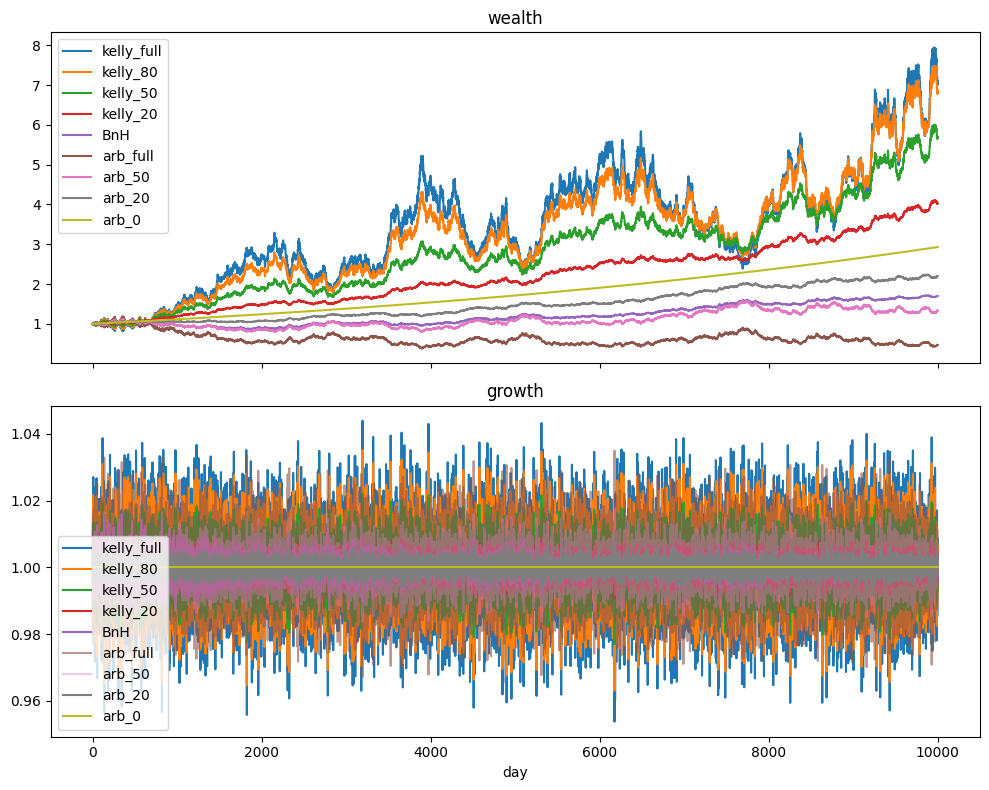

In [104]:
r = (1+0.04)**(1/365) -1
return_array = np.random.normal(0,0.01,10000)

kelly_full,growth_kelly_full = kelly( return_array,r,False,1)
kelly_80,growth_kelly_80 = kelly( return_array,r,False,0.8)
kelly_50,growth_kelly_50 = kelly( return_array,r,False,0.5)
kelly_20,growth_kelly_20 = kelly( return_array,r,False,0.2)
BnH_array,growth_BnH = BnH(return_array,r)
arb_full, growth_arb_full=arbitrary(return_array,r,1)
arb_50, growth_arb_50=arbitrary(return_array,r,0.5)
arb_20, growth_arb_20=arbitrary(return_array,r,0.2)
arb_0, growth_arb_0=arbitrary(return_array,r,0)

fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,8))

ax[0].plot(kelly_full,label="kelly_full")
ax[0].plot(kelly_80,label="kelly_80")
ax[0].plot(kelly_50,label="kelly_50")
ax[0].plot(kelly_20,label="kelly_20")
ax[0].plot(BnH_array,label="BnH")
ax[0].plot(arb_full,label="arb_full")
ax[0].plot(arb_50,label="arb_50")
ax[0].plot(arb_20,label="arb_20")
ax[0].plot(arb_0,label="arb_0")
ax[0].set_title('wealth')

ax[1].plot(growth_kelly_full,label="kelly_full")
ax[1].plot(growth_kelly_80,label="kelly_80")
ax[1].plot(growth_kelly_50,label="kelly_50")
ax[1].plot(growth_kelly_20,label="kelly_20")
ax[1].plot(growth_BnH,label="BnH")
ax[1].plot(growth_arb_full,label="arb_full",alpha=0.6)
ax[1].plot(growth_arb_50,label="arb_50",alpha=0.4)
ax[1].plot(growth_arb_20,label="arb_20")
ax[1].plot(growth_arb_0,label="arb_0")
ax[0].legend()
ax[1].legend()
ax[1].set_title('growth')
ax[1].set_xlabel('day')
plt.tight_layout()

From the graph, we can see that full kelly gives the largest wealth in the end, but its fluctuation fluctuation is also the largest. Also, it seems that BnH strategy is even worst than arb_0 (deposits all in the bank).

In [ ]:
#Other's codes
def Kelly(data, period, kelly_cap=None,kelly_frac=1):
    
    data['returns'] = data['Close'].pct_change()
    data['log_returns'] = np.log(data['Close'])-np.log(data['Close'].shift(1))
    data['rollstd'] = data.log_returns.rolling(period).std()
    data['rollmean'] = data.log_returns.rolling(period).mean()
    data['r_daily'] = np.log((1+data['1m_rate']) ** (1/period))
    
    # kelly value = ((mu - r) / sigma**2) * kelly_frac
    data['kelly_value'] = ((data['rollmean']-data['r_daily']) 
                            /data['rollstd']**2)*kelly_frac
    
    # convert to 0 all kelly_values that are <= 0 
    data['kelly_factor'] = np.where(data.kelly_value < 0, 0, data.kelly_value) 
    data['kelly_factor'] = np.where(data.kelly_factor >= kelly_cap, 
                                    kelly_cap, 
                                    data.kelly_factor)
    
    # put a max cap on the kelly factor
    if kelly_cap:
        data['kelly_factor'] = np.where(data.kelly_factor >= kelly_cap, 
                                        kelly_cap, 
                                        data.kelly_factor)
    data = data.dropna()
    
    return data

def monte_carlo_simulation(num_sims, sim_steps, X0, mu, sigma, T):
    '''
    num_sims (int): the number of simulations to run
    sim_steps (int): the number of steps in each simulation
    X0 (float): the initial value of the stock
    mu (float): expected return
    sigma (float): the volitility of the stock
    T (int): the time horizon of the simulation
    '''

    dt = T / sim_steps
    W = np.cumsum(np.random.randn(num_sims, sim_steps) * np.sqrt(dt), axis=1)
    X = X0 * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * W)
    # here dt should be np.array([n*dt for n in range(1,sims_steps+1)]) ?
    
    # calculate the mean and std
    final_vals = X[:, -1]
    mean = round(np.mean(final_vals), 2)
    stdev = round(np.std(final_vals), 2)

    return pd.Series([mean, stdev])

def fill_monte(data, period):
        
    # monte carlo for each iteration of the data so daily
    mc_results = data.apply(lambda row: monte_carlo_simulation(num_sims=10000, 
                                                               sim_steps=period,
                                                               X0=row['Close'], 
                                                               mu=row['rollmean'], 
                                                               sigma=row['rollstd'], 
                                                               T=1), axis=1)
    
    mc_results.rename(columns = {0:'mc_mean', 1:'mc_std'}, inplace = True)
    
    # join mc_mean and mc_std tuples as data columns
    data = data.join(mc_results)
    # create a column of the upper price bound (1 standard deviation from the mean)
    data['up1'] = data.mc_mean + data.mc_std
    # shift the up1, mc_mean, and mc_std columns by 1 day -- allows us to assess 
    # if we are outside the upper bound of the previous day's monte carlo 
    data[['up1', 'mc_mean', 'mc_std']] = data[['up1', 'mc_mean', 'mc_std']].shift(1)
        
    return data

def long_Kelly_strat(data, period, MC=False):
    
    # generates np array for length of sim to track portfolio ratios
    cash = np.zeros(data.shape[0])
    equity = cash.copy()
    portfolio = cash.copy()

    # starts portfolio and cash at 1
    portfolio[0] = 1
    cash[0] = 1
    equity[0] = 0

    for i, _row in enumerate(tqdm(data.iterrows())):
        if i >= 1:
            # this assigns row to all the data in 1 period of the data so the index, close, returns, log returns, kelly_factor
            row = _row[1]
            # If there is no kelly value then the portfolio just adds the previous time period's portfolio and cash
            if np.isnan(row['kelly_factor']):
                portfolio[i] += portfolio[i-1]
                cash[i] += cash[i-1]
                continue

            #reweights portfolio for each iteration of the data so daily 
            portfolio[i] += (cash[i-1] * (1 + row['r_daily'])) + (equity[i-1] * (1 + row['returns']))
            equity[i] += portfolio[i] * row['kelly_factor']
            cash[i] += portfolio[i] * (1- row['kelly_factor'])

    data['cash'] = cash
    data['equity'] = equity
    data['portfolio'] = portfolio
    data['strat_returns'] = data['portfolio'].pct_change()
    data['strat_log_returns'] = np.log(data['portfolio']) - np.log(data['portfolio'].shift(1))
    data['strat_cum_returns'] = data['strat_log_returns'].cumsum()
    data['cum_returns'] = data['log_returns'].cumsum()

    return data
